## Introductory Remarks:

   The system we're studying and working on for this project is that of a comet and the dust that is flung off of it over time. This "dust" is actually just different particles of a wide variety of sizes. For our considerations, there is a "maximum" size of dust that can be sent off of this comet (which we will cover in the code), however due to real world observations we know that this is only true for certain situations and that plenty of much larger pieces have fallen off. 
   
   Our main interest in this system is the speed that these small particles achieve, as well as the density of these particles in the coma of our comet (67P/Churyumov-Gerasimenko), and in order to find these things we had to take into account many different forces and measurements, such as the Radius of the dust, the radius of the nucleus of the comet, forces of gravity and of drag, as well as of the water/ice molecules sublimating off of the comet and increasing the speed of the dust grains. All of these are labeled in comments in the following code block.
   
   The goal of this section is to numerically solve the equation of motion:
       
$$M_{d}\frac{dv}{dt} = F_{g} + F_{d}$$
   
## Numerical Approach:
 
   In order to solve the problems given to us numerically we had to use different methods related to differential equations and calculus. In order to solve the first part of this problem, which was the velocity as a function of distance of different sized dust grains, I used the 2nd order Runge-Kutte Method so as to simulatenously calculate the radius and the velocity of the dust grain. I chose to do it in this fashion as the radius is based off of the velocity of the particle, however in order to calculate the velocity we aslo need to take into account the drag and gravitational forces, which rely on its distance (radius) from the nucleus. The calculations for the drag force as well as the gravitational force are simply functions that rely on variables which we calculate along the way, and are described in the code. 
   
   
#### 2nd order Runge-Kutte Solution Description:
   
   ##### Theorem of the Mean

You may recall the *Theorem of the Mean* from calculus.  This says that if I draw a line between two points along a function, then the function will have a derivative equal to the slope of this line at some point between the two points.  We can show why this might be useful by considering Figure 1 below.

<img src='P1_F1.png'>

*Figure 1*

In Figure 1, the left side shows an illustration of what we do when we use the derivative of the function at the beginning of the interval to predict later behavior.  If the derivative changes within the interval, as in this example, then this is not such an effective procedure.  The right side presents a possible solution which is motivated by the Theorem of the Mean.  Note that we expect that the slope defined by points that define the interval to be realized at some point within the interval.  The Second Order Runge-Kutta method makes an estimate of the derivative at the midpoint of the interval in an effort to improve the approximation.

##### Second Order Runge-Kutta Method

Our procedure with the Second Order Runge-Kutta Method is to begin by advancing the solution $\frac{1}{2}$ of a time step.  Lets call the solution at the midpoint of the interval $y(t_0+\frac{\Delta t}{2}) = y_{mid}$.  Similarly, we'll call the time at the mid-point $t+\frac{\Delta t}{2}  = t_{mid}$, then

$$y_{mid} \ = \ y_0 \ + \ f(y_0,t_0) \frac{\Delta t}{2}$$

We now use the differential equation to evaluate $\frac{dy}{dt}$ at the midpoint and then we advance the solution for a whole time step using this value for the derivative:

$$y(t_0+\Delta t) \ = \ y_0 \ + \ f(y_{mid},t_{mid}) \Delta t$$

(Taken from Exercise 9)


In order to calculate this process multiple times, I created a 2-Dimensional array which holds multiple runs of the Runge-Kutte computation. Each column is a separate run with a different value for the size of the dust grain being used, with the sizes ranging from 0.9 aMax to 0.001 aMax.

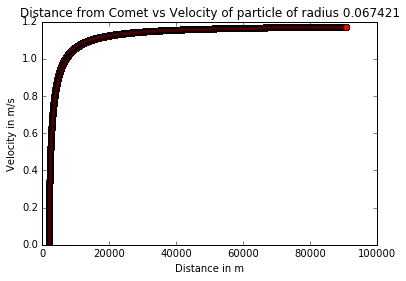

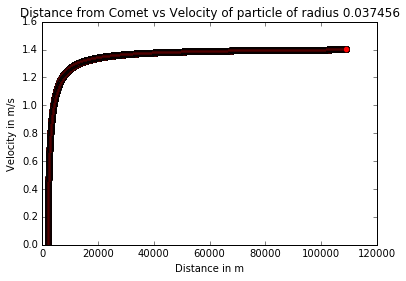

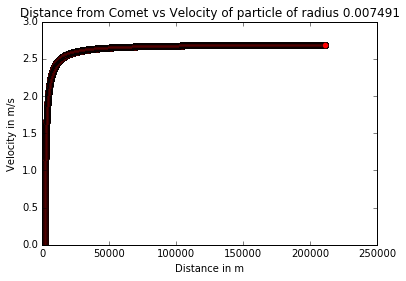

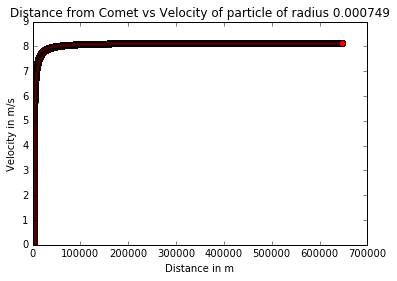

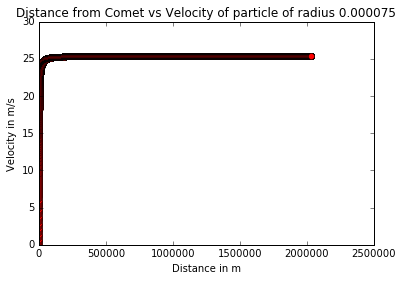

In [2]:
% matplotlib inline
import numpy as np
import matplotlib.pyplot as pl
import math
from numpy.random import RandomState
#Initialize basic parameters
R_i = 2000. # Nucleus radius, meters
GM_n = 667. # Nucleus mass, m^3/s^2
Q = 7.*10**27 # Gas Production Rate, molecules/s
v_g = 1000. # Gas Velocity, m/s
C_d = 4. # Drag Coefficient, dimensionless
P_d = 500. # Grain Density, kg/m^3
V_i = 0. # Initial Velocity, m/s
M_H20 = 2.99*10**-26 # mass of water molecule, kg

#Begin figuring out functions
P_gR = M_H20*Q/(4*np.pi*R_i**2*v_g)# Gas Density at comet's surface

aMax = (3./8.)*C_d*(v_g**2.)*P_gR*(1./P_d)*(R_i**2./GM_n) # Equation to figure out maximum dust grain size

M_d = lambda x: 4./3.*np.pi*((x*aMax)**3)*P_d  #mass of dust grain

r_Grain = lambda m: ((3*m)/(4*P_d*np.pi))**(1/3) #Radius of the grain as a function of its mass

def density(r):
    x =(M_H20*Q/(4*np.pi*R_i**2*v_g))*(R_i**2/(r)**2) # Gas Density at radius r
    return x  

def F_d(P_g, v, a): # finding the drag force on a particle of size a, density of p_g, and speed of v
    x = .5*C_d*((v_g-v)**2)*np.pi*P_g*a**2
    return x
        
    
def F_g(M_d, r): # Finding the gravitational force on dust grain of size M_d, distance r away
    x =-1*(GM_n*M_d)/(r**2)
    return x

# SECOND ORDER RUNGE_KUTTA SOLUTION

#size and radius of different dust grains for use in calculations
Radii= [r_Grain(M_d(0.9)),r_Grain(M_d(0.5)),r_Grain(M_d(0.1)),r_Grain(M_d(0.01)),r_Grain(M_d(0.001))]
size= [M_d(0.9),M_d(0.5),M_d(0.1),M_d(0.01),M_d(0.001)]
#Defining how often we calculate our radius and velocity for how many points
dt = 1
npoints = 80000
#defining our radius and velocity arrays
R = np.zeros([npoints,len(size)])
V = np.zeros([npoints,len(size)])
R[0,:] = R_i*np.ones(len(R[0,:]))
V[0,:] = V_i*np.ones(len(R[0,:]))


#outer loop exists in order to save the data on all 5 dust grain variances in our 2D R and V arrays. 
for j in range(5):
    for i in range(npoints-1):
        # compute midpoint position (not used!) and  velocity         
        Rmid = R[i,j] + V[i,j]*dt/2.
        drag = F_d(density(R[i,j]),V[i,j],Radii[j])
        grav = F_g(size[j], R[i,j])
        Vmid = V[i,j] + (drag-grav)/size[j]*dt/2.
        # use midpoint velocity to advance position            
        R[i+1,j] = R[i,j] + Vmid*dt
        V[i+1,j] = V[i,j] + (drag-grav)/size[j]*dt
        
    pl.plot(R[:,j], V[:,j], 'ro-')
    pl.title("Distance from Comet vs Velocity of particle of radius %f" %Radii[j] )
    pl.xlabel('Distance in m')
    pl.ylabel('Velocity in m/s')
    pl.show()


As we can see above, the smaller a dust grain's radius, and thus the smaller its size, the fast it approaches its terminal velocity, which is also faster as the dust grain is smaller. This falls in line with our given equations in the project description on the gravitational force:

$$F_{g} = -\frac{GM_{N}M_{d}}{r^2}$$


### Terminal Velocity Vs. Grain Size:

In this section, I calculate the terminal velocity of many different sizes of dust grain in order to showcase the steep change in the grain's speed in relation to its size. Although the project state that we should use the 5 grain sizes we calculated in the previous section, I felt as though using many different masses more clearly showed the correlation between grain size and terminal velocity, and as such I calculated the terminal velocity for 1000 different grain sizes between a size of 0 and 0.9aMax. We once more use the 2nd order Runge-Kutte method to calculate these velocities and take the velocity at a very far distance in order to make sure it has reached the terminal point.

C:\Users\Owner\Anaconda3\lib\site-packages\ipykernel\__main__.py:21: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Owner\Anaconda3\lib\site-packages\ipykernel\__main__.py:24: RuntimeWarning: invalid value encountered in double_scalars


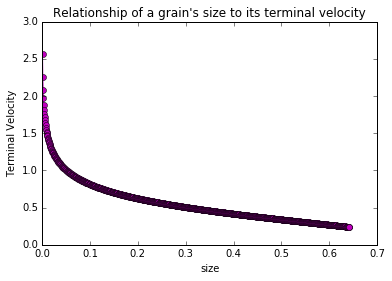

In [5]:
sizeMany = np.linspace(0,M_d(0.9),1000)
RadiiMany = r_Grain(sizeMany)
npoints = 40000
RMany = np.zeros([npoints,len(sizeMany)])
VMany = np.zeros([npoints,len(sizeMany)])
RMany[0,:] = R_i*np.ones(len(RMany[0,:]))
VMany[0,:] = V_i*np.ones(len(VMany[0,:]))


for j in range(1000):
    for i in range(npoints-1):
        # compute midpoint position (not used!) and  velocity         
        Rmid = RMany[i,j] + VMany[i,j]*dt/2.
        drag = F_d(density(RMany[i,j]),VMany[i,j],RadiiMany[j])
        grav = F_g(sizeMany[j], RMany[i,j])
        Vmid = VMany[i,j] + (drag+grav)/sizeMany[j]*dt/2.
        # use midpoint velocity to advance position            
        RMany[i+1,j] = RMany[i,j] + Vmid*dt
        VMany[i+1,j] = VMany[i,j] + (drag+grav)/sizeMany[j]*dt
        

termVel = np.zeros(1000)

for y in range(1000):
    termVel[y] = VMany[npoints-1,y]
pl.title('Relationship of a grain\'s size to its terminal velocity')
pl.plot(sizeMany, termVel, 'mo-')
pl.xlabel('size')
pl.ylabel('Terminal Velocity')
pl.show()


As we can see above in both sets of graphs, just like we would assume, the smaller the grain size the higher its terminal velocity, as well as being an exponential rise. This makes sense, as our equation for the force of gravity is based off of 1/r^2


### 3.2 Part 2: Determination of Number Density of Particles:

  In this section, we must figure out the number density of the particles as different distances from the nucleus.
Doing this is relatively simple, as we were given the equation we needed to use and we had already calculated the potentially unknown variables in the previous section of this project. To make sure my output was proper, I checked that the slope was following apporximately x^-2 in the log-log graph using the grids, and at the important sections it was as such. The portion of the graph that does not follow this slope also makes sense, as our equation approaches a singularity at 0, which also explains the RuntimeWarning we get for dividing by 0 in our code block below.

C:\Users\Owner\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()


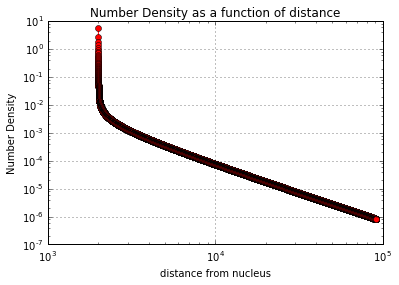

In [3]:
a = M_d(0.9) #The particle size we will be working with for this part
q = 100000 #Production rate of particles
numDens_R = q/(4*np.pi*(R[:,0]**2)*V[:,0]) #taking data from previous for loops, index 0 holds data of particle of size a

pl.plot(R[:,0],numDens_R, 'ro-')
pl.title('Number Density as a function of distance')
pl.xlabel('distance from nucleus')
pl.ylabel('Number Density')
pl.yscale('log')
pl.xscale('log')
pl.grid()
pl.show()

### Final Section 3.3: Calculation of the Column Density

   For this section of the project we had to calculate the density of an infinitely sized column of the dust at different distances from the comet. In order to do this, we theoretically have to take the integral from negative infinity to positive infinity of the number density of the column. In order to do this numerically, I calculated up until a point where the numbers became relatively static, and multiplied by two in order to consider both above and below the point I integrated from. I used the trapezoidal sum integration method which we learned in class, which certain modifications. I changed the arguments the function takes to only recieve a beginning and ending point for the integration, and used these points to calculate the number N of trapezoids to create. 
   
   In order to check the accuracy of my graph, I printed out the slope at certain points throughout the graph, as well as created a graph showcasing it's change over time. My slope at the important sections of the graph fell into the proper range between -1 and -1.6, while slowly approaching -1 as distance increased, as the description for the project predicted. 

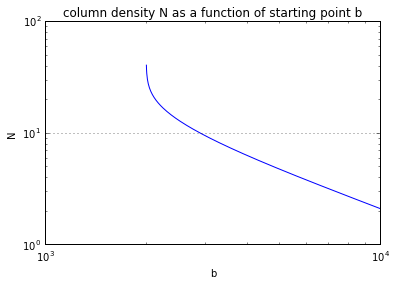

The following 3 numbers are slopes are different points during the above graph, ranging from the beginning to the middle to the end of it.
-1.55679193945
-1.22649845384
-1.15038683083


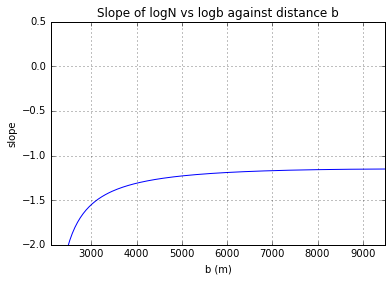

In [15]:
b = R[100:10000:50,0]

def trap(t0,t1):

    # set the locations for evaluation of y
    b = R[t0,0]
    r = R[t0+1:t1,0]
    n = q/(4*np.pi*(R[t0:t1+1,0]**2)*V[t0:t1+1,0])
    ds = np.ones(len(r))
    N = len(ds)
    for i in range(len(ds)-1):
        ds[i] = (r[i]*(r[i+1]-r[i])) / math.sqrt(r[i]**2 - b**2)
    # now add up the boxes to approximate the area
    integral = 0.
    for i in range(N-1):
        integral = integral + 2*((n[i] + n[i+1])/2)*ds[i]
    # return the result
    return(integral)

colDens = np.ones(len(b))
for j in range(len(colDens)):
    colDens[j] = trap(100+j*50,80000)

pl.plot(b,colDens)
pl.title("column density N as a function of starting point b")
pl.xlabel('b (m)')
pl.ylabel('N')
pl.yscale('log')
pl.xscale('log')
pl.grid()
pl.show()


slopeEarly = ((np.log(colDens[50]) - np.log(colDens[49])) / (np.log(b[50]) - np.log(b[49]))) 
slopeMid = ((np.log(colDens[100]) - np.log(colDens[99])) / (np.log(b[100]) - np.log(b[99])))
slopeLate = ((np.log(colDens[197]) - np.log(colDens[196])) / (np.log(b[197]) - np.log(b[196])))
print("The following 3 numbers are slopes are different points during the above graph, ranging from the beginning to the middle to the end of it.")
print(slopeEarly)
print(slopeMid)
print(slopeLate)
slope = np.ones(len(b))
for i in range(len(b)-1):
    slope[i] = ((np.log(colDens[i+1]) - np.log(colDens[i])) / (np.log(b[i+1]) - np.log(b[i])))
pl.plot(b,slope)
pl.title("Slope of logN vs logb against distance b")
pl.axis([2100,9500,-2,0.5])
pl.ylabel('slope')
pl.xlabel('b (m)')
pl.grid()
pl.show()

## Final Interpretation of results:

Q: *So, finally, the question to be answered is whether the effect of accelerating the large dust particles can
provide an adequate explanation of the observation that the MIRO emission decreases with b as $b^{−1.6}$. Without acceleration of the dust particles, we’d have observed $b^{−1}$. Can just the expected acceleration account for the difference?*

A: I do not think that the expected acceleration is the only thing that accounts for the difference in the numbers. The reason for this is that even when we do account for acceleration, our slope never actually reaches -1 or close to -1, rather it reaches around -1.15 which is relatively far from our point of interest. There are many potential causes for this difference. One option is that some of the dust grains do not actually end up rising and accelerating off of the comet. This could occur because the dust grains may be jagged pieces of rock which do not have uniform drag on them, unlike our assumption of perfect spheres with equal drag force throughout.
  Another possibility is that some of the dust sublimates with the water molecules and simply disappears over time which could also explain the difference in finding, as we lose more dust in this scenario than in our simulations. Another reasonable possibility is that it is a combination of these two scenarios which work together to remove enough dust grains that would account for the difference between the observations of MIRO and our calculations.